In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
from tensorflow.keras.applications import ResNet50
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import tensorflow as tf

# Create three independent generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  # don't shuffle for evaluation/prediction
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

import tensorflow as tf

def identity_block(x, filters):
    f1, f2, f3 = filters
    shortcut = x

    x = Conv2D(f1, (1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f2, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f3, (1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def conv_block(x, filters, strides=(2,2)):
    f1, f2, f3 = filters
    shortcut = x

    # Main path
    x =Conv2D(f1, (1,1), strides=strides)(x)
    x =BatchNormalization()(x)
    x =ReLU()(x)
    x =Conv2D(f2, (3,3), padding='same')(x)
    x =BatchNormalization()(x)
    x =ReLU()(x)
    x =Conv2D(f3, (1,1))(x)
    x =BatchNormalization()(x)

    # Shortcut path
    shortcut =Conv2D(f3, (1,1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)

    # Merge
    x = Add()([x, shortcut])
    x =ReLU()(x)
    return x

def ResNet50_Model(input_shape=(1024,1024,3), classes=4):
    inputs =Input(shape=input_shape)
    x = Conv2D(64, (7,7), strides=(2,2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = conv_block(x, [64, 64, 256], strides=(1,1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512])
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024])
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048])
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])
        
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

resnet50_model = ResNet50_Model()
resnet50_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 512, 512, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_265 (BatchN (None, 512, 512, 64) 256         conv2d_265[0][0]                 
__________________________________________________________________________________________________
re_lu_245 (ReLU)                (None, 512, 512, 64) 0           batch_normalization_265[0][0]    
____________________________________________________________________________________________

In [9]:
from tensorflow.keras.optimizers import Adam

# Create your model
resnet50_model = ResNet50_Model()

# Compile the model
opt = Adam(learning_rate=0.0001)
resnet50_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=5,
    verbose=1,
    cooldown=1,
    min_delta=0.0001
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

check_path = '/content/drive/MyDrive/resnetOwn.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# Fit the model
hist_scratch = resnet50_model.fit(
    train_generator,
    validation_data=val_generator,  # ✅ use val_generator, not test_generator
    epochs=30,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/30
417/417 [==============================] - 74s 168ms/step - loss: 0.9737 - accuracy: 0.5793 - val_loss: 1.3844 - val_accuracy: 0.4922

Epoch 00001: val_loss improved from inf to 1.38441, saving model to /content/drive/MyDrive\resnetOwn.weights.h5
Epoch 2/30
417/417 [==============================] - 66s 157ms/step - loss: 0.8672 - accuracy: 0.6216 - val_loss: 1.2758 - val_accuracy: 0.5735

Epoch 00002: val_loss improved from 1.38441 to 1.27579, saving model to /content/drive/MyDrive\resnetOwn.weights.h5
Epoch 3/30
417/417 [==============================] - 66s 159ms/step - loss: 0.8193 - accuracy: 0.6419 - val_loss: 1.2141 - val_accuracy: 0.5506

Epoch 00003: val_loss improved from 1.27579 to 1.21414, saving model to /content/drive/MyDrive\resnetOwn.weights.h5
Epoch 4/30
417/417 [==============================] - 66s 158ms/step - loss: 0.7708 - accuracy: 0.6674 - val_loss: 1.0031 - val_accuracy: 0.5766

Epoch 00004: val_loss improved from 1.21414 to 1.00311, saving model to 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0, 0.5, 'Loss')

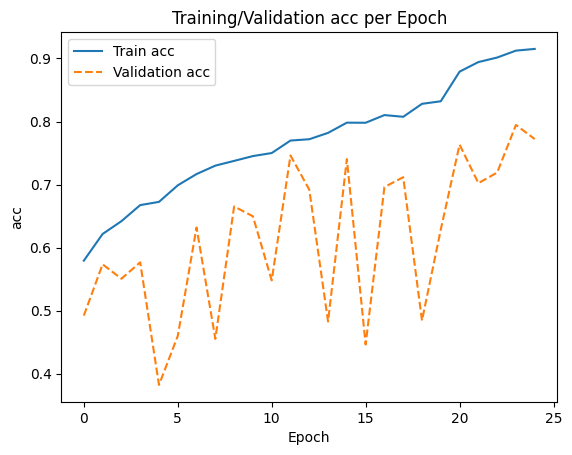

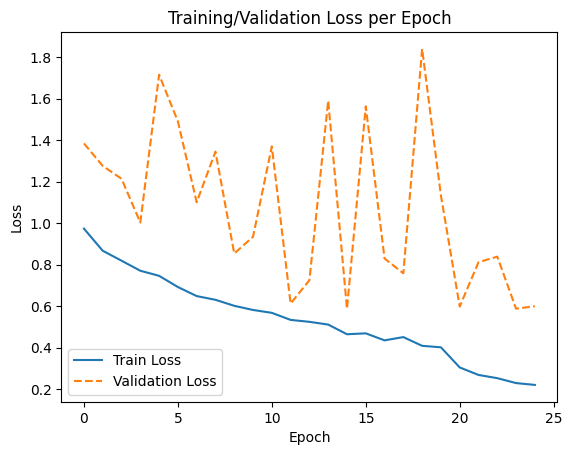

In [10]:
# Plot the model accuracy on training and validation data
print(hist_scratch.history.keys())

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['accuracy'])
ax.plot(hist_scratch.history['val_accuracy'], '--')
ax.legend(['Train acc', 'Validation acc'])
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

# Plot the model loss on training and validation data
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['loss'], )
ax.plot(hist_scratch.history['val_loss'], '--')
ax.legend(['Train Loss', 'Validation Loss'])
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [11]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =resnet50_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'A': 0, 'B': 1, 'C': 2, 'D': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[3 3 3 ... 2 3 3]


In [12]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.7184841453982985
F1 0.6672733128601493
precision 0.7365808507875871
recall 0.681516638668927
jaccard 0.5186233687356623
classification_report
               precision    recall  f1-score   support

           0       0.99      0.75      0.85       466
           1       0.81      0.33      0.46       233
           2       0.64      0.89      0.74       411
           3       0.51      0.77      0.61       183

    accuracy                           0.72      1293
   macro avg       0.74      0.68      0.67      1293
weighted avg       0.78      0.72      0.71      1293




[[348   3  12 103]
 [  0  76 153   4]
 [  2  14 365  30]
 [  0   1  42 140]]
